# Chapter 4 - Pathways 4.2 and 4.3

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import glob
import numpy as np
import pickle 
import statistics as st
import seaborn as sb
import random as rd

### Input

In [2]:
class SuperPathwayClass:
    def __init__(self, name,idPathway,geneSet,networkWithCCs,networkLCC,drivers):
        self.name = name
        self.idPathway = idPathway
        self.geneSet = geneSet
        self.networkCCs = networkWithCCs
        self.networkLCC = networkLCC
        self.drivers = drivers
        self.topologicalFeaturesLCC = None
        self.layout_LCC_kamada_kawai= None
        self.layout_CCs_spring = None
        
    def info(self):
        info={}
        info['Name'] = self.name
        info['idPathway'] = self.idPathway        
        info['lenSet'] = len(self.geneSet)
        info['lenCCs'] = str(len(self.networkCCs.nodes)) +' ('+str(round(len(self.networkCCs.nodes)/len(self.geneSet)*100))+'%)'
        info['lenLCC'] = str(len(self.networkLCC.nodes)) +' ('+str(round(len(self.networkLCC.nodes)/len(self.geneSet)*100))+'%)'       
        driversLen = len(self.drivers)
        info['driversLCC'] = driversLen
        info['drivers %'] = round(driversLen/len(self.networkLCC.nodes)*100)
        
        return info

In [9]:
file = open("inputs/superPathwaysObjs.pkl", "rb")
superPathwaysObjs = pickle.load(file)
overView={}
for k in sorted(superPathwaysObjs):
    overView[k]=superPathwaysObjs[k].info()
    
overViewDf=pd.DataFrame.from_dict(overView,orient='index')
overViewDf.set_index(overViewDf.columns[0],inplace=True)
overViewDf.sort_values(by=['drivers %'],ascending=False).head()

idPathway  lenSet      lenCCs      lenLCC  \
Name                                                                    
Chromatin organization  R-HSA-4839726     240   218 (91%)   206 (86%)   
Circadian Clock          R-HSA-400253      70    69 (99%)    64 (91%)   
DNA Repair                R-HSA-73894     312   290 (93%)   284 (91%)   
Reproduction            R-HSA-1474165     114    95 (83%)    81 (71%)   
Disease                 R-HSA-1643685    1888  1513 (80%)  1415 (75%)   

                        driversLCC  drivers %  
Name                                           
Chromatin organization          45         22  
Circadian Clock                 12         19  
DNA Repair                      48         17  
Reproduction                    14         17  
Disease                        206         15

##### Rename the column names

In [5]:
for name in superPathwaysObjs:
    superPathwaysObjs[name].topologicalFeaturesLCC.rename(
        columns={
            'degree':'Degree',
            'kcore':'Kcore',
            'eigenvector':'Eigenvector',
            'averageNeighbor': 'AvgNeighbors', 
            'clusteringcoeff': 'Clustering',
            'leverage': 'Leverage',
            'eccentricity': 'Eccentricity',
            'betweenness': 'Betweenness',
            'closeness': 'Closeness',
            'bridging': 'Bridging',
        },inplace=True)
    superPathwaysObjs[name].topologicalFeaturesLCC

### 4.2  Pathways Databases and Representation

##### Plotando GeneSet Vs Nertowks

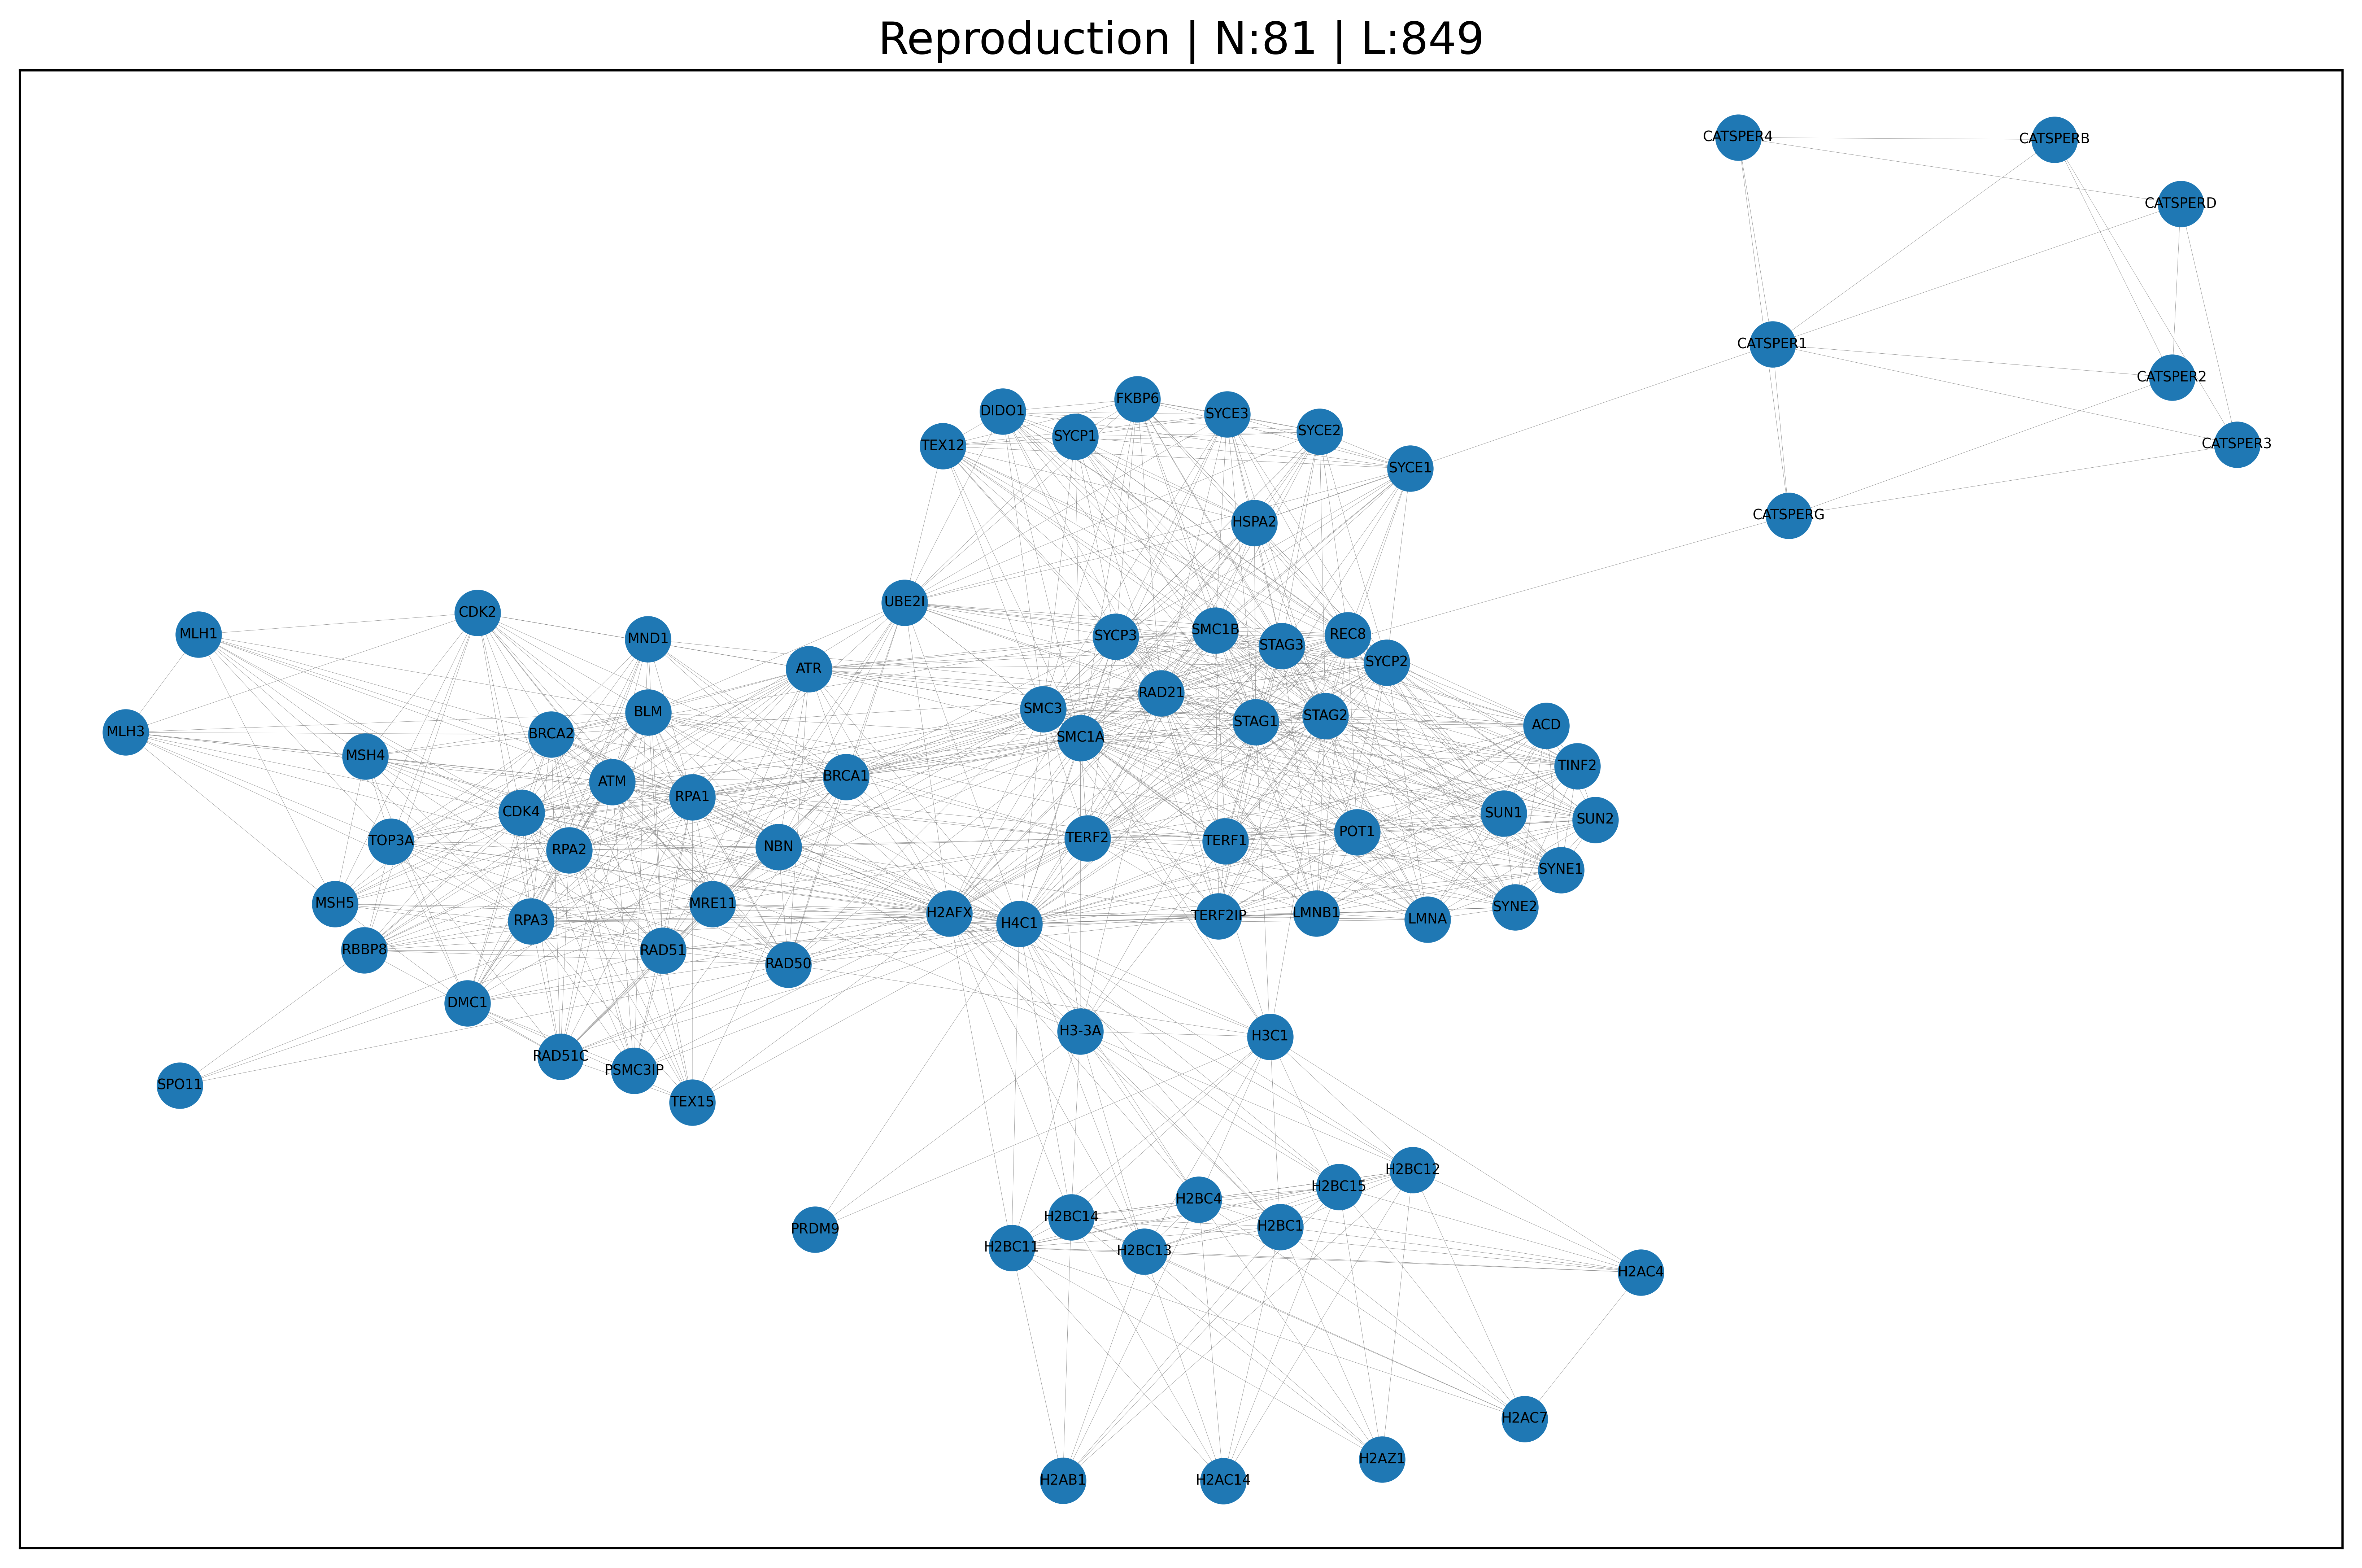

In [6]:
obj = superPathwaysObjs['Reproduction']
G=obj.networkLCC
pos=obj.layout_LCC_kamada_kawai
name=obj.name+' | N:'+str(G.number_of_nodes()) + ' | L:'+str(G.number_of_edges())
allNodes = list(G.nodes())
plt.figure(figsize=(12,8),dpi=550)

nx.draw_networkx_nodes(G, pos=pos, node_size=250, nodelist=allNodes, node_color='#1f78b4',node_shape='o')
nx.draw_networkx_edges(G, pos=pos, alpha=1, edge_color='gray',width=0.1)
nx.draw_networkx_labels(G, pos=pos,font_size=5)

plt.title(name,fontsize=16)
plt.tight_layout()

# plt.savefig(obj.name+".png", format='png', dpi=550)
# plt.savefig(obj.name+".svg", format='svg')

plt.show()

### Plotting SuperPathways as Direct Graph

In [7]:
reactome_df = pd.read_csv("../../Datasets/networks/reactome/Reactome2019_FIsInGene_020720_with_annotations.txt",sep='\t')
reactome_df.head()

Gene1    Gene2                    Annotation Direction  Score
0  16-5-5    CDC42                     predicted         -   0.98
1  16-5-5    PARD3                     predicted         -   1.00
2  16-5-5   PARD3B                     predicted         -   1.00
3    A1CF  APOBEC1  catalyzed by; complex; input        <-   1.00
4    A1CF    EP300       expression regulated by        <-   1.00

In [34]:
reactomeEdges={}
for row in reactome_df.iterrows():
    key=(row[1]['Gene1'],row[1]['Gene2'])
    reactomeEdges[key]=[row[1]['Direction'],row[1]['Score']]

In [35]:
def getDirectEdges(v1,v2):
    if (v1,v2) in reactomeEdges:
        edge=(v1,v2)
    elif (v2,v1) in reactomeEdges:
        edge=(v2,v1)
    else:
        print('Edge not found')#this should not happen
    
    score=reactomeEdges[edge][1]    
    edgeType=reactomeEdges[edge][0]
    
    if(edgeType=='-'):
        pass
    elif(edgeType=='->'):
        pass
    elif(edgeType=='-|'):
        pass
    elif(edgeType=='<->'):
        pass
    elif(edgeType in ['|->','<-|','|-|']):#There no way to visual represente these edges. Luckly there only 2k
        edgeType='-'
    elif(edgeType=='<-'):
        edgeType='->'
        edge=(edge[1],edge[0])
    elif(edgeType=='|-'):
        edgeType='-|'
        edge=(edge[1],edge[0]) 
    else:
        print('Type not found')#this should not happen
    
    return edge,edgeType,score

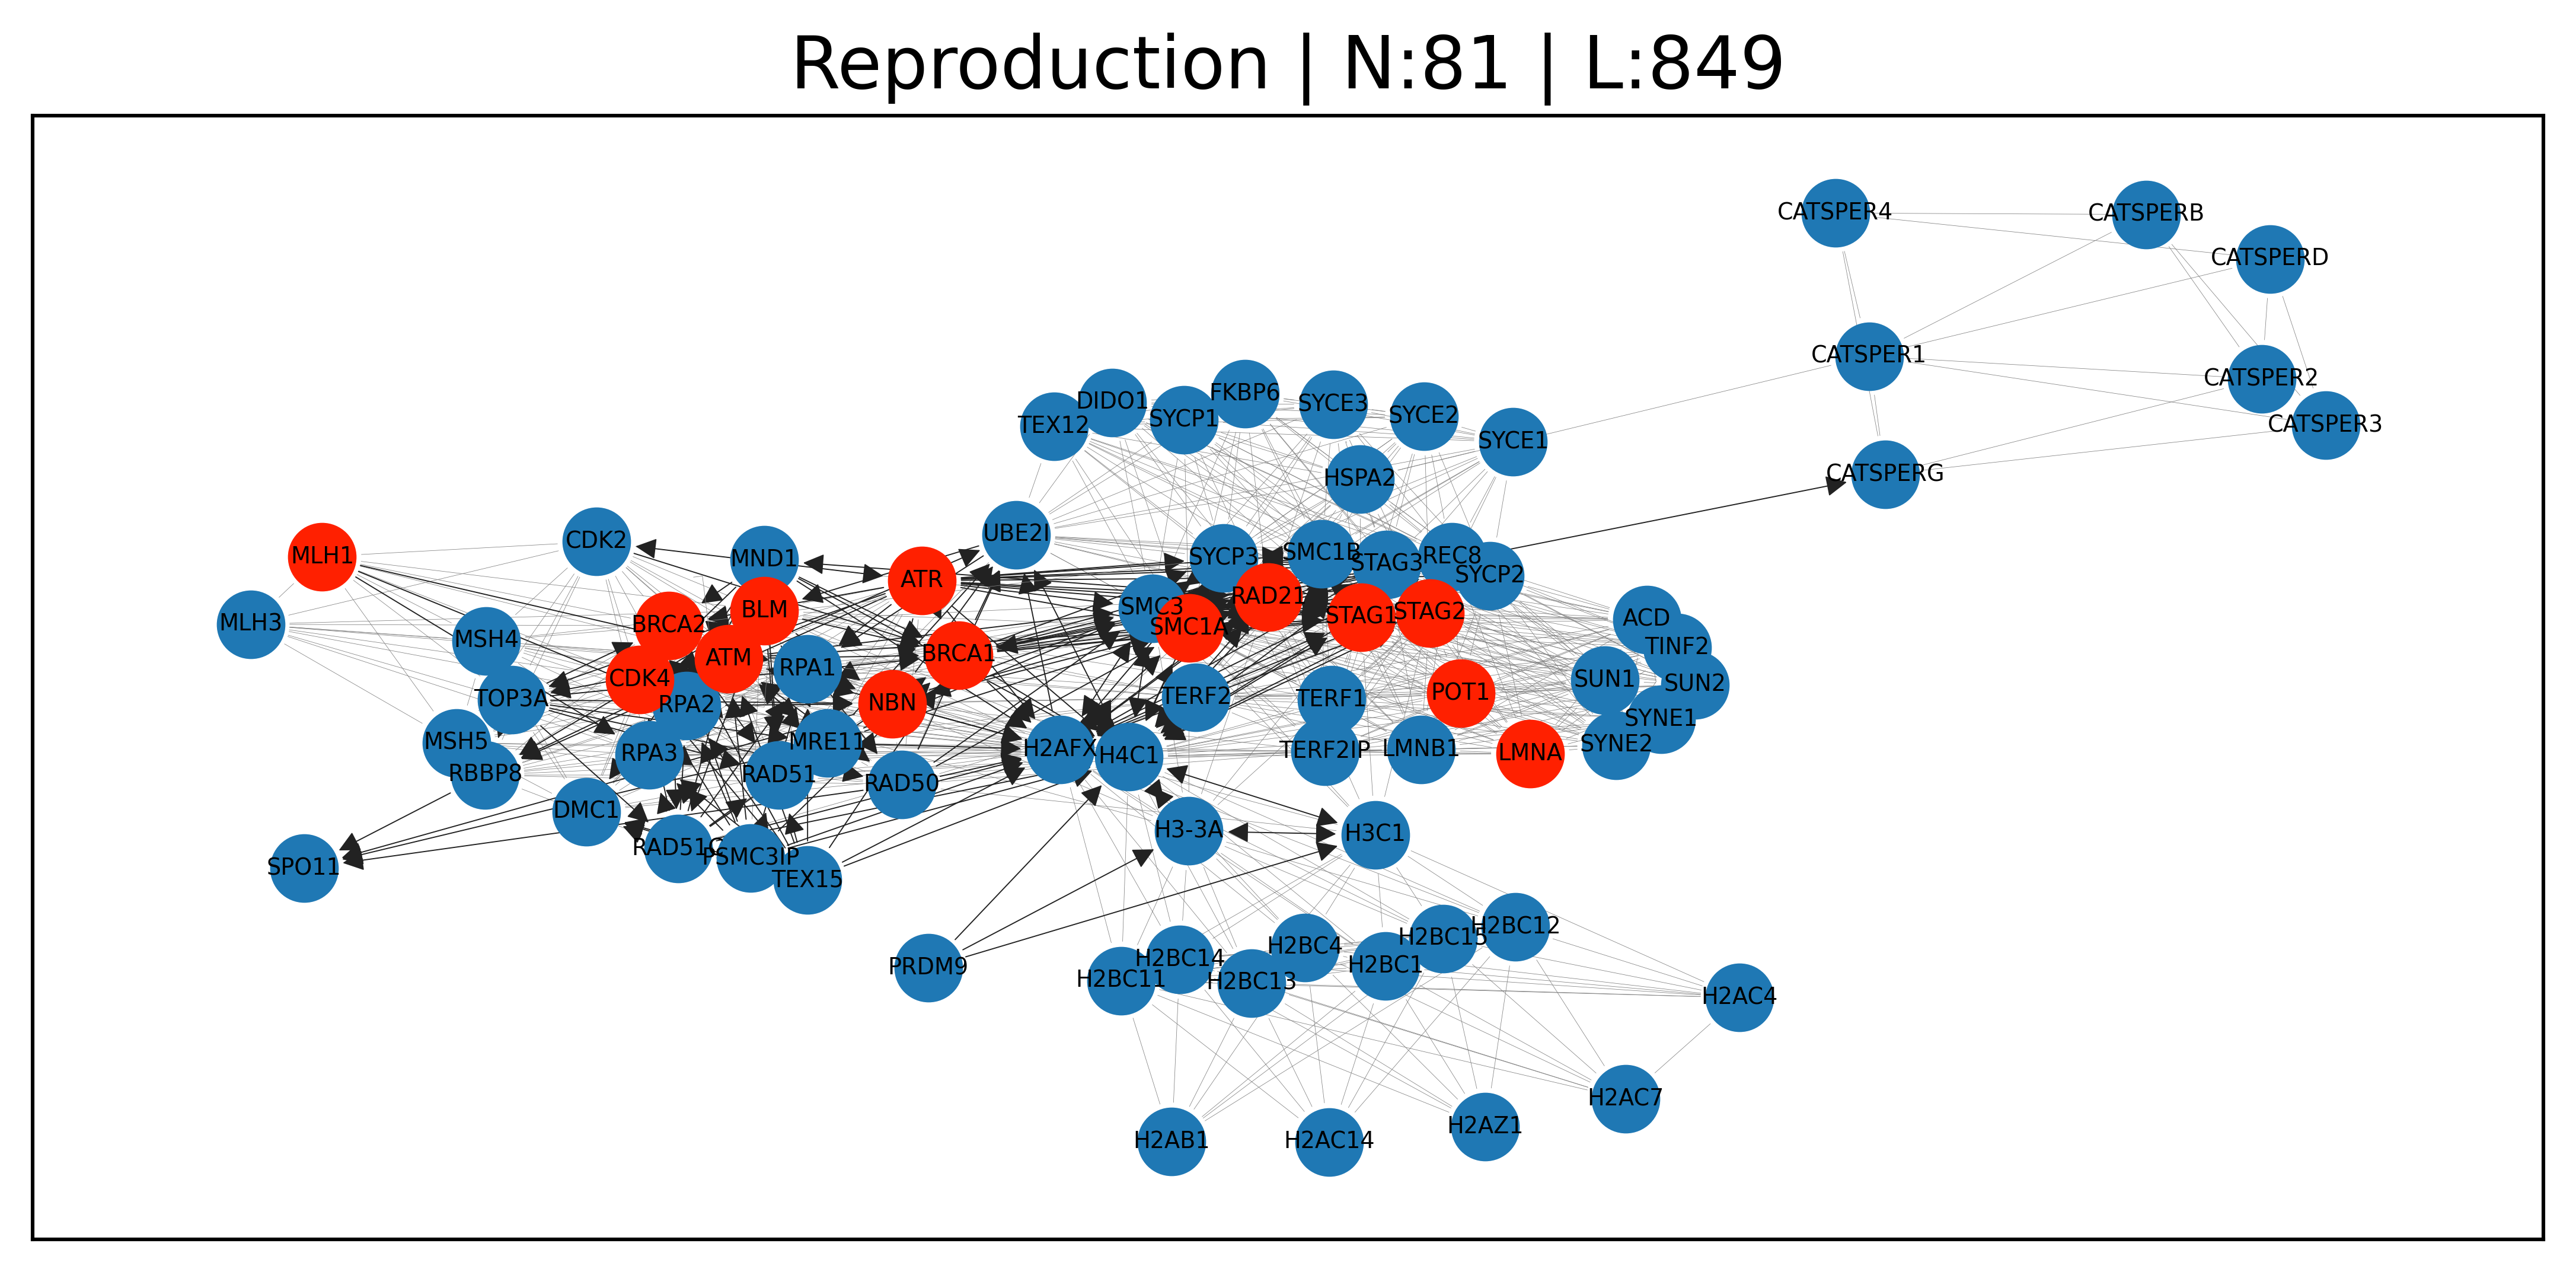

In [36]:
#Get the data from the Undirect SuperPathway Network
obj = superPathwaysObjs['Reproduction']
G=obj.networkLCC
pos=obj.layout_LCC_kamada_kawai
name=obj.name+' | N:'+str(G.number_of_nodes()) + ' | L:'+str(G.number_of_edges())
allNodes = list(G.nodes())
plt.figure(figsize=(8,4),dpi=550)

#Create a Direct Network
Digraph = nx.DiGraph()
for v1,v2 in G.edges():
    EdgeTypeScore = getDirectEdges(v1,v2)
    Digraph.add_edge(*EdgeTypeScore[0],weight=EdgeTypeScore[2],type=EdgeTypeScore[1])


edgesWeight = nx.get_edge_attributes(Digraph,'weight')
edgesTypes = nx.get_edge_attributes(Digraph,'type')
nx.draw_networkx_edges(Digraph,pos=pos,arrowstyle='-'     ,edgelist=[edge for edge,t in edgesTypes.items() if t=='-'],  alpha=1, edge_color='gray',width=0.1)
nx.draw_networkx_edges(Digraph,pos=pos,arrowstyle='-|>'   ,edgelist=[edge for edge,t in edgesTypes.items() if t=='->'], alpha=1, edge_color='#222',width=0.25)
nx.draw_networkx_edges(Digraph,pos=pos,arrowstyle='<|-|>' ,edgelist=[edge for edge,t in edgesTypes.items() if t=='<->'],alpha=1, edge_color='#222',width=0.25)
nx.draw_networkx_edges(Digraph,pos=pos,arrowstyle='-['    ,edgelist=[edge for edge,t in edgesTypes.items() if t=='-|'], alpha=1, edge_color='gray',width=0.1)
nx.draw_networkx_edges(Digraph,pos=pos,arrowstyle=']-['   ,edgelist=[edge for edge,t in edgesTypes.items() if t=='|-|'],alpha=1, edge_color='gray',width=0.1)
# nx.draw_networkx_edge_labels(Digraph,edge_labels=edgesWeight,pos=pos,font_size=2)
nx.draw_networkx_labels(Digraph,pos=pos,font_size=5)

#nx.draw_networkx_nodes(Digraph, pos=pos, node_size=250, nodelist=allNodes, node_color='#1f78b4',node_shape='o')


others = [node for node in G.nodes() if node not in drivers]
        

nx.draw_networkx_nodes(Digraph, pos=pos, node_size=200, nodelist=others, node_color='#1f78b4', label='Other Genes',node_shape='o',alpha=1)
nx.draw_networkx_nodes(Digraph, pos=pos, node_size=200, nodelist=drivers, node_color='#FF2000', label='drivers',node_shape='o')

plt.title(name,fontsize=16)
plt.tight_layout()

# plt.savefig(obj.name+"_edges.png", format='png', dpi=550)
# plt.savefig(obj.name+"_edges.svg", format='svg')

plt.show()

### 4.3  Pathways Analyses

In [8]:
GS1=['BRCA1','BRCA2','SMC1A','STAG1','STAG2' ]
GS2=['CATSPER1', 'CATSPER2', 'CATSPER3', 'CATSPER4', 'CATSPERB']

In [16]:
35.6/21

1.6952380952380952

In [17]:
21/4.6

4.565217391304349

In [18]:
print(np.mean(list(dict(nx.degree(G)).values())))
print(np.mean(list(dict(nx.degree(G,nbunch=GS1)).values())))
print(np.mean(list(dict(nx.degree(G,nbunch=GS2)).values())))

20.962962962962962
35.6
4.6


In [19]:
print(np.mean(list(dict(nx.clustering(G)).values())))
print(np.mean(list(dict(nx.clustering(G,nodes=GS1)).values())))
print(np.mean(list(dict(nx.clustering(G,nodes=GS2)).values())))

0.7722100384112554
0.604393107019646
0.48571428571428577


In [40]:
dict(nx.degree(G,nbunch=GS2))

{'CATSPER1': 7, 'CATSPER2': 4, 'CATSPER3': 4, 'CATSPER4': 4, 'CATSPERB': 4}

In [20]:
print(np.mean(list(dict(nx.cluster.square_clustering(G)).values())))
print(np.mean(list(dict(nx.cluster.square_clustering(G,nodes=GS1)).values())))
print(np.mean(list(dict(nx.cluster.square_clustering(G,nodes=GS2)).values())))

0.38184878398119365
0.11701996160020176
0.7095


In [21]:
print(np.mean(list(dict(nx.closeness_centrality(G)).values())))
print(np.mean([value for gene,value in dict(nx.closeness_centrality(G)).items() if gene in GS1]))
print(np.mean([value for gene,value in dict(nx.closeness_centrality(G)).items() if gene in GS2]))

0.48939445912149376
0.5887468589023305
0.31000067009371735


In [22]:
print(np.mean(list(dict(nx.betweenness_centrality(G)).values())))
print(np.mean([value for gene,value in dict(nx.betweenness_centrality(G)).items() if gene in GS1]))
print(np.mean([value for gene,value in dict(nx.betweenness_centrality(G)).items() if gene in GS2]))

0.014291295514924206
0.020310047525265926
0.012570974477247754


In [23]:
Digraph.out_degree(GS1)

OutDegreeView({'BRCA1': 25, 'BRCA2': 19, 'SMC1A': 21, 'STAG1': 18, 'STAG2': 17})

In [24]:
Digraph.in_degree(GS1)

InDegreeView({'BRCA1': 9, 'BRCA2': 9, 'SMC1A': 23, 'STAG1': 18, 'STAG2': 19})

In [29]:
9+9+23+18+19+17+18+21+19+25

178

In [48]:
len([ (edge,arrow) for edge, arrow in dict(edgesTypes).items() if (edge[0] in GS1 or edge[1] in GS1) and arrow=='<->' ])

32